In [54]:
import torch
import math
import numpy as np
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.io import read, write
from ase import Atom, Atoms
import time
import os
import sys
import pickle
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import py3Dmol
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import gc
import zipfile
import pandas as pd
from tqdm import tqdm

import datetime
import matplotlib.pyplot as plt
import random
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device: ", device)

# This ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# This ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Device:  mps
True
True


In [2]:
species = ["H", "O"]   
rcut = 2.0      # Cut off radius in Angs
nmax = 4      # number of radial basis functions
lmax = 4      # number of spherical harmonics

# Setting up the SOAP descriptor
soap_obj = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    weighting={"function":"poly","r0":1.5,"c":2,"m":2}
)

In [3]:
subsample=5
datapath = '../../DeePCDP-dev/water-data/cube-h2o-2k/'
datafilename = 'h2o-ELECTRON_DENSITY-1_'
data_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) for x in data_files]
cubefile = lambda x:f'{datapath}{x}'
CDP=deepcdp(soap_obj)
CDP.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)
totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])
data_files = os.listdir(datapath)
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
data_files_sub = random.choices(data_files, k=subsample)
CDP.generate_cube_data(data_files_sub,cubefile,sampleSubs)

Read file: ../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1919.cube
SOAP is of dimension: (68921, 180)
Read file: ../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_404.cube
Read file: ../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_808.cube
Read file: ../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1111.cube
Read file: ../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1818.cube


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.6638e-18, -1.2124e-18, -8.5074e-19, ..., -2.3576e-16,
         9.9146e-17,  2.9781e-16]))

In [145]:
# Define the model class

torch.manual_seed(1)

class Network(torch.nn.Module):        
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Network, self).__init__()
        hidden_1, hidden_2, hidden_3 = hidden_sizes
        layers = [
            nn.Linear(input_size, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, output_size)
        ]
        
        self.layers = nn.Sequential(*layers)
        
#         nn.init.normal_(self.layers[0].weight)
#         nn.init.normal_(self.layers[0].bias)
#         nn.init.normal_(self.layers[2].weight)
#         nn.init.normal_(self.layers[2].bias)
#         nn.init.normal_(self.layers[4].weight)
#         nn.init.normal_(self.layers[4].bias)
#         nn.init.normal_(self.layers[6].weight)
#         nn.init.normal_(self.layers[6].bias)
    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -1, 1)
        

    def forward(self, A0):
        x = self.layers(A0)
        return x

In [5]:
batch_size=500
data_batch = int(CDP.trainX.shape[0]/batch_size)
data_batch*batch_size

344500

In [6]:
soaps=Variable(torch.Tensor(CDP.trainX))
rhos=Variable(torch.Tensor(CDP.trainY))

In [146]:
batch_size=200
# Define the hyperparameters
num_epochs = 20
learning_rate = 1e-3

# Define the model and loss function

model = Network(soaps.shape[1], [100,100,100], 1).to(device)


criterion = nn.MSELoss() # TODO: Change the loss function to include number of electronds constraint
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True, threshold=0.01)


training_samples = utils_data.TensorDataset(soaps, rhos)
data_loader_trn = utils_data.DataLoader(training_samples, batch_size=batch_size, drop_last=False, shuffle=True)

In [33]:
# torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler_state_dict' : scheduler.state_dict(),
#     }, f"water_model_"+str(epoch))

In [80]:
model_dict=torch.load('../../DeePCDP-dev/saved_models/water/water_model_44p4')
model.load_state_dict(model_dict['model_state_dict'])
optimizer.load_state_dict(model_dict['optimizer_state_dict'])
scheduler.load_state_dict(model_dict['scheduler_state_dict'])

In [ ]:
# Train the model
cum_loss_epoch=[]
for epoch in range(num_epochs):
    batch_bar = tqdm(total=len(data_loader_trn), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    cum_loss = 0
    # Convert inputs and labels to tensors
    
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        inputs = (data.float()).to(device)
        labels = (target.float()).reshape(-1,1).to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss+=loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(cum_loss),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    batch_bar.close()
    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        num_epochs,
        float(cum_loss), 
        float(float(optimizer.param_groups[0]['lr']))
        ))

    scheduler.step(cum_loss)
    cum_loss_epoch +=[cum_loss]
    np.savetxt('../../DeePCDP-dev/saved_models/water/cum_loss_water_100init.dat',cum_loss_epoch)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cum_loss:.4f}')
        plt.plot(model(soaps.to(device)).cpu().detach().numpy())
        plt.plot(rhos, alpha=0.5)
        plt.show()
#     print()
    if (epoch+1)%2==0:
        acc=skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)
        print(acc)
        
    if (epoch+1) % 5 == 0:
        
        print('Saving model')
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
    }, f"../../DeePCDP-dev/saved_models/water/water_model_100init"+str(epoch))
#     print()

Epoch 1/20: Train Loss 0.1181, Learning Rate 0.0010


Epoch 2/20: Train Loss 0.0954, Learning Rate 0.0010
0.9510206245173357


Epoch 3/20: Train Loss 0.0797, Learning Rate 0.0010


Epoch 4/20: Train Loss 0.0745, Learning Rate 0.0010
0.9422334187219806


Epoch 5/20: Train Loss 0.0784, Learning Rate 0.0010
Saving model


Train:   6%|  | 101/1724 [00:01<00:28, 56.81it/s, loss=0.0084, lr=0.0010]

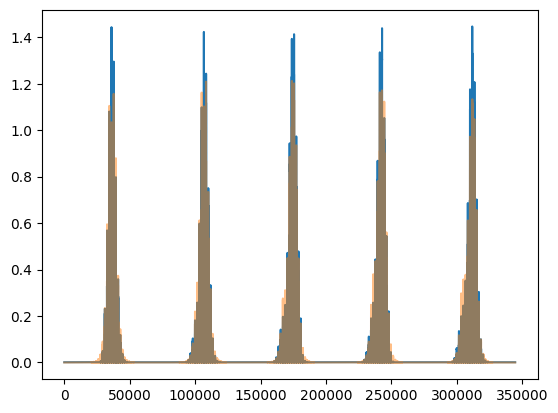

In [92]:
model.eval()
plt.plot(model(soaps.to(device)).cpu().detach().numpy())
plt.plot(rhos, alpha=0.5)

In [93]:
skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)

0.9589948385408191

In [140]:
model.eval()
pred=model(soaps.to(device)).cpu().detach().numpy()[0:70000]

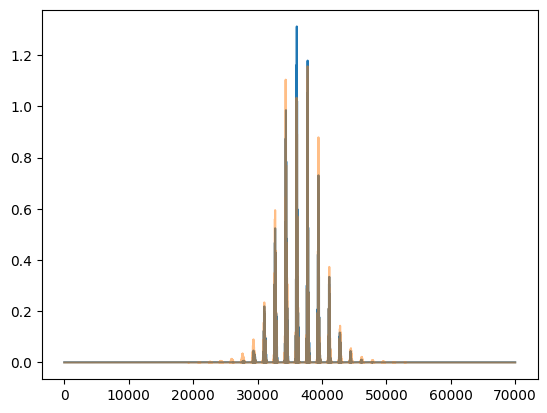

In [144]:
plt.plot(pred)
plt.plot(rhos[0:70000],alpha=0.5)
# plt.ylim(-0.05,0.05)

In [113]:
CDP.cube2xyz('../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1616.cube','example/structures/water/water-1616.xyz')

In [114]:
ase_atoms_test.get_positions()

array([[4.09454518, 3.69783743, 3.31343358],
       [3.28374092, 3.82717945, 3.75176112],
       [4.11527093, 4.2569793 , 2.52993063]])

In [137]:
# Testing 1616 water structure
model.eval()
test_cube_path = '../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1616.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = soap_obj.create(ase_atoms_test, positions=CDP.box)
rho_pred = model(torch.tensor(soap_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
skmetrics.r2_score(rho_test,rho_pred)

Prediction time:  0.5822930335998535  seconds.


0.9647454968797384

In [133]:
# Here we obtained the total number pf points along x, y and z and the
# spacing matrix
CDP.bounds
# noPoints, cell_spacing=CDP.get_NoPoints_spacing_matrix()
# x_f, y_f, z_f = noPoints
# redefine get_NoPoints_spacing_matrix() as a separate function. 

(41, 41, 41)

In [138]:
out=open('example/predictions/water/pred-1616.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP.box[0])
# TODO: use predictions to create a cube file 

In [139]:
# water_xyz=open('example/structures/water/water-1616.xyz').read()
# # print(water_xyz)
# xyzview = py3Dmol.view(width=400,height=400)
# xyzview.addModel(water_xyz,'xyz')
# xyzview.setStyle({'stick':{}})
# xyzview.zoomTo()
# xyzview.show()

water_cube_predict=open('example/predictions/water/pred-1616.cube').read()
water_cube_dft=open(test_cube_path).read()
CDP.cube2xyz(test_cube_path,'example/structures/water/water-1616.xyz')
water_xyz=open('example/structures/water/water-1616.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(water_cube_predict,'cube',{'isoval': 0.03,"color":'red','opacity':0.75,'wireframe':True})
xyzview.addVolumetricData(water_cube_dft,'cube',{'isoval': 0.03,"color":'grey','opacity':0.75,'wireframe':True})
xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [119]:
# training a model
start = time.time()
model_water_2 = MLPRegressor(hidden_layer_sizes=(100,100,100),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                           batch_size=500).fit(CDP.trainX, CDP.trainY) ## Building NN
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  83.89722895622253  seconds.


In [120]:
file_name = 'model_4.sav'
pickle.dump(model_water_2, open(file_name,'wb'))

In [121]:
skmetrics.r2_score(model_water_2.predict(CDP.trainX),CDP.trainY)

0.9777893768423722

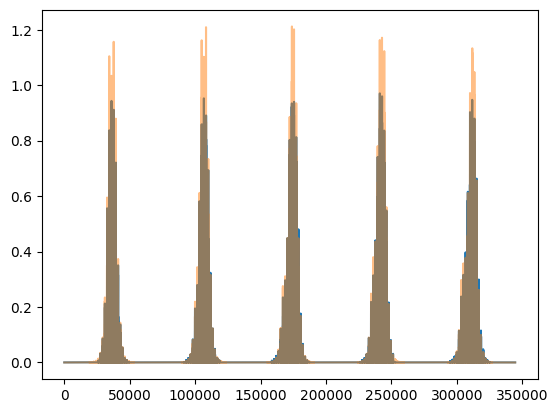

In [123]:
plt.plot(model_water_2.predict(CDP.trainX))
plt.plot(CDP.trainY,alpha=0.5)

In [124]:
# Testing 1616 water structure
test_cube_path = '../../DeePCDP-dev/water-data/cube-h2o-2k/h2o-ELECTRON_DENSITY-1_1111.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = soap_obj.create(ase_atoms_test, positions=CDP.box)
rho_pred = model_water_2.predict(soap_test)

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
skmetrics.r2_score(rho_test,rho_pred)

Prediction time:  0.5214500427246094  seconds.


0.9820215496446046

In [125]:
out=open('example/predictions/water/pred_sk-1111.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP.box[0])

In [126]:
# water_xyz=open('example/structures/water/water-1616.xyz').read()
# # print(water_xyz)
# xyzview = py3Dmol.view(width=400,height=400)
# xyzview.addModel(water_xyz,'xyz')
# xyzview.setStyle({'stick':{}})
# xyzview.zoomTo()
# xyzview.show()

water_cube_predict=open('example/predictions/water/pred_sk-1111.cube').read()
water_cube_dft=open(test_cube_path).read()
CDP.cube2xyz(test_cube_path,'example/structures/water/water-1111.xyz')
water_xyz=open('example/structures/water/water-1111.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(water_cube_predict,'cube',{'isoval': 0.03,"color":'red','opacity':0.75,'wireframe':True})
xyzview.addVolumetricData(water_cube_dft,'cube',{'isoval': 0.03,"color":'grey','opacity':0.75,'wireframe':True})
xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol